In [1210]:
using Flight
using ControlSystems

In [1211]:
ac = Cessna172Rv0(NED()) |> System #must use NED kinematics
ac.u.airframe.pld.m_pilot = 75
ac.u.airframe.pld.m_copilot = 75
ac.u.airframe.pld.m_lpass = 0
ac.u.airframe.pld.m_rpass = 0
ac.u.airframe.pld.m_baggage = 0

trim_params = C172Rv0.TrimParameters(
    loc = LatLon(),
    h = HOrth(1000),
    ψ_nb = 0.0,
    TAS = 40.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel = 1,
    mixture = 0.5,
    flaps = 0.0)

lm = linearize!(ac; trim_params)

LinearStateSpace{16, 4, 17, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_filt = 14, ω_eng = 15, fuel = 16)}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(throttle = 1, aileron = 2, elevator = 3, rudder = 4)}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, TAS = 10, α = 11, β = 12, f_x = 13, f_y = 14, f_z = 15, ω_eng = 16, m_fuel = 17)}}}, ComponentArrays.ComponentMatrix{Float64, Matrix{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_filt = 14, ω_eng = 15, fuel = 16)}, ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_fil

In [1891]:
long_dyn = filter(lm;
    u = (:elevator, :throttle),
    x = (:v_x, :v_z, :θ, :q, :α_filt, :ω_eng),
    y = (:q, :θ, :α, :TAS, :f_x, :f_z, :ω_eng))

long_dyn_ss = long_dyn |> ss
long_dyn_tf = long_dyn_ss |> tf

#could reduce the model further for CAS by omitting omega_eng and throttle
pitch_dyn = filter(lm; u = (:elevator,),
    x = (:v_x, :v_z, :θ, :q, :α_filt),
    y = (:q, :θ, :α, :TAS))

pitch_dyn_ss = pitch_dyn |> ss
pitch_dyn_tf = pitch_dyn_ss |> tf


TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
Input 1 to output 1
 9.268525497714286s^4 + 199.90768157061498s^3 + 315.63256196214013s^2 + 24.97604514782593s + 0.00045740912139535794
---------------------------------------------------------------------------------------------------------------------
1.0s^5 + 26.762188942772774s^4 + 224.4230421414663s^3 + 980.3166956427975s^2 + 98.61165871131901s + 87.21311875765586

Input 1 to output 2
  -7.105427357601002e-15s^4 + 9.268509139757157s^3 + 199.90732849002654s^2 + 315.63197987354334s + 24.9756301690648
---------------------------------------------------------------------------------------------------------------------
1.0s^5 + 26.762188942772774s^4 + 224.4230421414663s^3 + 980.3166956427975s^2 + 98.61165871131901s + 87.21311875765586

Input 1 to output 3
  0.10240291573187577s^4 + 11.441562289975735s^3 + 188.81036462796112s^2 + 19.878193982903085s + 21.449831179005656
-----------------------------------------------

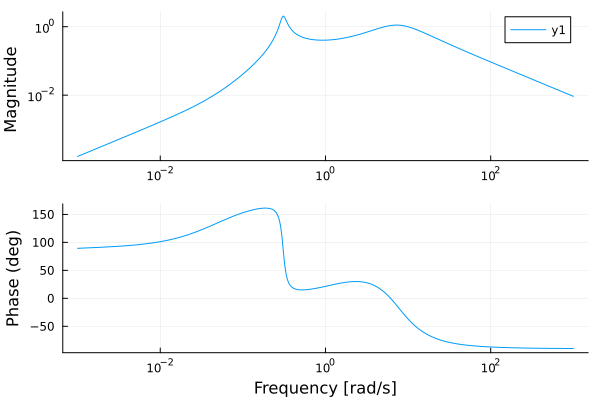

In [1989]:
#extract the elevator to q transfer function
e2q = long_dyn_tf[1,1]
bodeplot(e2q)


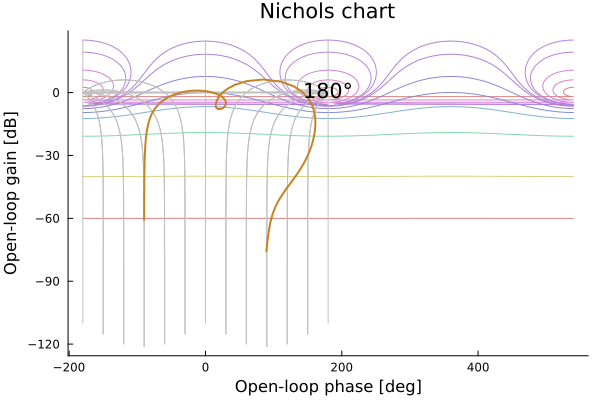

In [1991]:
nicholsplot(e2q)

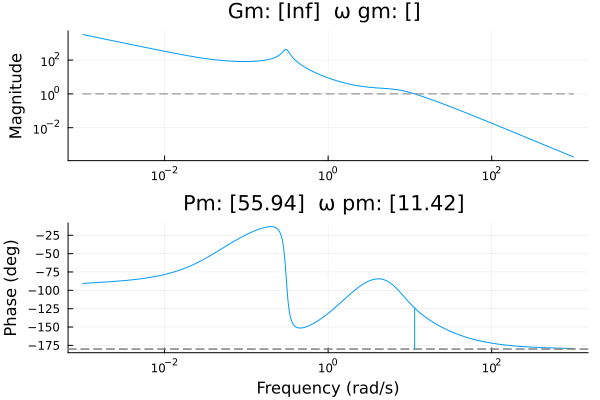

In [1998]:
#our first requirement for the the pitch rate CAS is finite steady-state error
#for a step input. we see that there are no pure integrations or derivatives in
#the open-loop TF, so in theory we have a type 0 system. however, there are two
#zeros that are very close to the origin, so the open loop behaves almost as a
#double derivative. if we add two integrators, in the (very) long term the
#system will behave as a type 2 system. however, in the short term, the two
#integrators will essentially cancel the derivatives and allow for a type 0
#behavior. in practice, what we will do is add an integrator in series followed
#by a PID

#rather than aiming for minimum steady state error (since the outward θ loop
#doesn't really care for that), we want good stability margins

# k_p = 20
# k_i = 5
# k_d = 0.5
k_p = 10
k_i = 20
k_d = 0.5
q_comp = tf(1, [1, 0]) * (k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [0.05, 1]))
    
e2q_c = series(q_comp, e2q)
cl = feedback(e2q_c, 1)

marginplot(e2q_c)
# lsim(cl, (x,t)->[sin(2π*t),], 0:0.01:5) |> plot


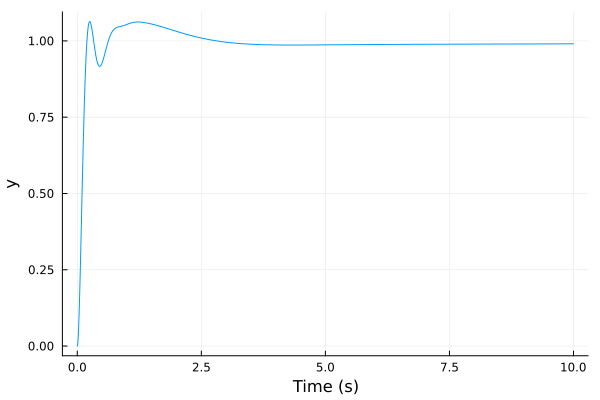

In [1940]:
step(cl, 10) |> plot

So, now we have a SISO compensator design for q, let's use to close the loop in the MIMO plant. The long_dyn MIMO system has two inputs, elevator and throttle. So we need a MIMO version of our SISO compensator, which will be placed upstream of the MIMO plant, applying the SISO compensator only on the first input and letting the second pass through unchanged to the plant.

The first input to this MIMO compensator will be q_err, and its second input, the throttle input u_t. It must apply the SISO feedforward compensator above to q_err, and a unit gain to u_t. This is achieved as follows:

In [1941]:
q_comp_MIMO = append(q_comp, tf(1)) |> ss #should convert to ss before concatenation

StateSpace{Continuous, Float64}
A = 
 0.0  2.0    0.0
 0.0  0.0    8.0
 0.0  0.0  -20.0
B = 
 0.0  0.0
 0.0  0.0
 8.0  0.0
C = 
 3.125  3.4375  2.5
 0.0    0.0     0.0
D = 
 0.0  0.0
 0.0  1.0

Continuous-time state-space model

In [1970]:
q_comp_long_dyn = series(q_comp_MIMO, long_dyn_ss) #equivalent to long_dyn_ss * q_comp_MIMO (in the product notation, the second system goes first)

StateSpace{Continuous, Float64}
A = 
 -0.17013308901206833    1.4318904966379975    -9.738239460317288      -1.1271381308238233  -28.24856895242189    0.016378881697729112    -18.22448352599606   -20.046931878595665  -14.579586820796848
 -0.27853266244991015   -2.3733627980412275    -0.8717967309822257     38.40353776935116     13.897325354127688   0.00039899446504846426   11.220021557876914   12.342023713664606    8.97601724630153
  1.571882694985941e-7   1.407212047940821e-8  -9.947777075500862e-14   0.9999983285598668    0.0                 0.0                       0.0                  0.0                  0.0
  0.1769331921495966    -2.229674785575077     -3.904915762298344e-6   -4.218693055719373    48.72591896956027    0.004363078866599174     28.964142180357133   31.860556398392845   23.171313744285705
 -0.04458387856753928    0.49800831878448054    0.0                     0.0                 -20.0                 0.0                       0.0                  0.0              

The setpoint vector to be applied to the closed-loop MIMO system is r = [q_cmd, u_t]. The input to the MIMO compensator must be e = [q_err, u_t] = r - f = [q_cmd, u_t] - [q, 0]. So we need a matrix gain that premultiplies the 7-component output vector of long_dyn, and produces a 2-component vector [q, 0]. This will be a 2x7 matrix with all entries set to zero except [1, 1] (the nonzero output goes in the first component, and q is the first element in long_dyn's output vector)

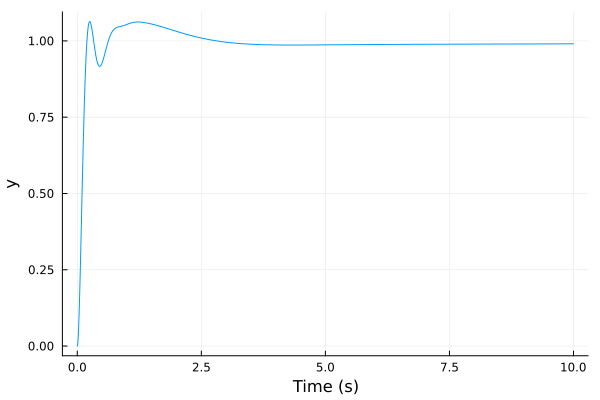

In [1986]:
K_select = zeros(2, 7)
K_select[1,1] = 1
K_ss = ss(K_select) #creates a ss with no dynamics and K_select as feedthrough

#now create a feedback loop with K in the feedback path
q_comp_long_dyn_cl = feedback(q_comp_long_dyn, K_ss)

#this is similar, but NOT equivalent: it uses unit feedback, which means that
#the whole 7 component output vector from q_comp_long_dyn is fed back, and then
#multiplied by K_ss in the feedforward path before entering the compensator.
#this yields a 7 input system, of which only the two first inputs actually do
#anything (the others get discarded when they pass through K)
# q_comp_long_dyn_cl = feedback(series(K_ss, q_comp_long_dyn))

e2q_cl_MIMO = (q_comp_long_dyn_cl |> tf)[1,1]

q_comp_long_dyn_cl.B

#we make sure that the step response is the same as the one in the SISO design
#task 
step(e2q_cl_MIMO, 10) |> plot


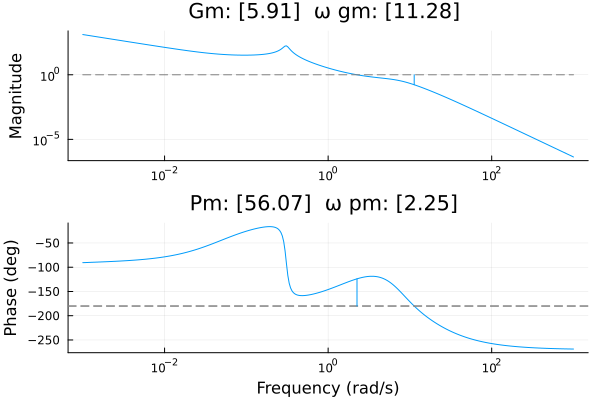

In [1958]:
#let's see what we could achieve if we had an actuator in the loop with a 5Hz
#time constant

k_p = 3.4
k_i = 8
k_d = 0.3
q_comp = tf(1, [1, 0]) * (k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [0.05, 1]))
act = tf(1, [0.2, 1])
    
e2q_c = q_comp * act * e2q
cl = feedback(e2q_c, 1)

marginplot(e2q_c)
bodeplot(act)


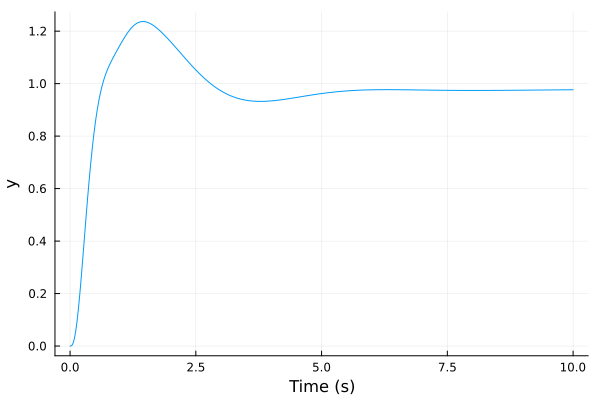

In [1959]:
step(cl, 10) |> plot

In [1960]:
# world = SimpleWorld(Cessna172Rv0(LTF())) |> System; #for simulation, we use LTF kinematics

In [1961]:
# #trim for the trim conditions above and simulate
# (success, result) = trim!(world; trim_params)
# @assert success
# sim = Simulation(world; t_end = 30, adaptive = true)
# Sim.run!(sim, verbose = true)
# # plots = make_plots(sim; Plotting.defaults...)
# plots = make_plots(TimeHistory(sim).ac.kinematics; Plotting.defaults...)
# save_plots(plots, save_folder = joinpath("tmp", "trim_sim_test"))